# Multi-Arm Bandits Problem with Reinforcement Learning

This project is extended from:

https://towardsdatascience.com/multi-armed-bandits-and-reinforcement-learning-dc9001dcb8da

Here, we illustrate the effects of
- $\epsilon$, which is the probability of exploring (in constrast to exploiting)
- Decay, which reduces the probability of exploring over time

$\epsilon$ is important as exploring different options allow the agent to find path to a global maxima, in constrast to getting trapped within a local maxima

Meanwhile, decay is important as we wish to stop exploring after a period of time, as the global maxima may have be found

The best implementation is to use both concepts together.

# Import Libraries

In [1]:
# import modules 
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
from tqdm import tqdm
%matplotlib inline

np.random.seed(42)

# We define different reward distribution
- Random
- Increasing
- Gaussian
- Sin

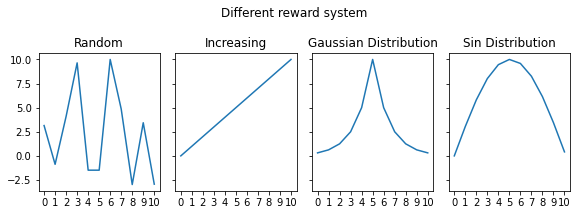

In [2]:
k = 11
np.random.seed(42)

fig, axs = plt.subplots(1,4, figsize=(8, 3), 
                        facecolor='w', edgecolor='k', 
                        sharex=True, sharey=True)

fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

reward_1 = np.random.normal(0, 10, k)
reward_2 = np.linspace(0, k-1, k)
reward_3 = np.array([2**x for x in range(int(np.ceil(k/2)))] + [2**x for x in range(int(np.floor(k/2)))][::-1])
reward_4 = np.sin(np.arange(0, np.pi, 0.31))

reward_1 = 10*reward_1/np.max(reward_1)
reward_2 = 10*reward_2/np.max(reward_2)
reward_3 = 10*reward_3/np.max(reward_3)
reward_4 = 10*reward_4/np.max(reward_4)

axs[0].plot(reward_1)
axs[0].set_title("Random")
axs[0].set_xticks(list(range(0,k)))
    
axs[1].plot(reward_2)
axs[1].set_title("Increasing")
axs[1].set_xticks(list(range(0,k)))

axs[2].plot(reward_3)
axs[2].set_title("Gaussian Distribution")
axs[2].set_xticks(list(range(0,k)))

axs[3].plot(reward_4)
axs[3].set_title("Sin Distribution")
axs[3].set_xticks(list(range(0,k)))

plt.suptitle('Different reward system')
fig.tight_layout()
plt.show()

# Building a greedy k-Armed Bandit

We compare the k-bandit problem, with and without decay
First, we predefine the epsilon, which is the probability of exploring
If decay is enabled, the probability decrease 0.00001 per time step.

In [3]:
class eps_bandit:
    '''
    epsilon-greedy k-bandit problem
    
    Inputs
    =====================================================
    k: number of arms (int)
    eps: probability of random action 0 < eps < 1 (float)
    iters: number of steps (int)
    mu: set the average rewards for each of the k-arms.
        Set to "random" for the rewards to be selected from
        a normal distribution with mean = 0. 
        Set to "sequence" for the means to be ordered from 
        0 to k-1.
        Pass a list or array of length = k for user-defined
        values.
    '''
    
    def __init__(self, k, eps, iters, mu='random', decay=False):
        
        self.k = k                    # Number of arms
        self.eps = eps                # Search probability
        self.iters = iters            # Number of iterations
        self.n = 0                    # Step count
        self.k_n = np.zeros(k)        # Step count for each arm
        self.mean_reward = 0          # Total mean reward
        self.reward = np.zeros(iters) 
        self.k_reward = np.zeros(k)   # Mean reward for each arm
        self.decay = decay         # Set decay
        
        if type(mu) == list or type(mu).__module__ == np.__name__:        
            self.mu = np.array(mu)
        elif mu == 'random':
            np.random.seed(42)
            self.mu = reward_1
        elif mu == 'sequence':
            self.mu = reward_2
        elif mu == 'gaussian':
            self.mu = reward_3
        elif mu == 'sin':
            self.mu = reward_4     
        
        
    def pull(self):
        # Generate random number
        p = np.random.rand()
        if self.eps == 0 and self.n == 0:
            a = np.random.choice(self.k)
        elif p < self.eps:
            # Randomly select an action
            a = np.random.choice(self.k)
        else:
            # Take greedy action
            a = np.argmax(self.k_reward)
            
        reward = np.random.normal(self.mu[a], 1)
        
        # Update counts
        self.n += 1
        self.k_n[a] += 1
        
        # Update total
        self.mean_reward = self.mean_reward + (reward - self.mean_reward) / self.n
        
        # Update results for a_k
        self.k_reward[a] = self.k_reward[a] + (reward - self.k_reward[a]) / self.k_n[a]
        
        # Decay eps
        if self.decay == True:
            self.eps = self.eps - 0.00001
        
    def run(self):
        for i in range(self.iters):
            self.pull()
            self.reward[i] = self.mean_reward
            
    def reset(self):
        # Resets results while keeping settings
        self.n = 0
        self.k_n = np.zeros(k)
        self.mean_reward = 0
        self.reward = np.zeros(iters)
        self.k_reward = np.zeros(k)

# Test for different $\epsilon$ and decay

100%|██████████| 3/3 [00:04<00:00,  1.42s/it]


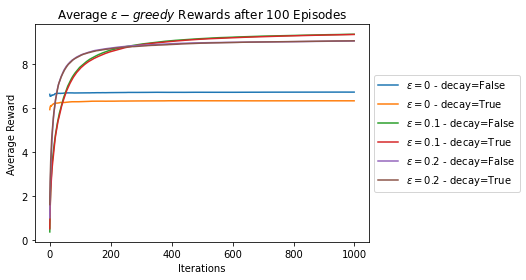

In [14]:
iters = 1000

eps_reward_list = []
eps_selection_list = []

episodes = 100
epsilon_list = [0, 0.1, 0.2]
decay_list = [False, True]

plt.figure(figsize=(6,4))

max_reward = []

# Run experiments
for epsilon in tqdm(epsilon_list):
    for decay in decay_list:
        eps_rewards = np.zeros(iters)
        eps_selection = np.zeros(k)

        for i in range(episodes):
            # Initialize bandits
            eps = eps_bandit(k, epsilon, iters, 
                             #mu='random',
                             #mu='sequence',
                             #mu='gaussian',
                             mu='sin',
                             decay=decay,
                            )

            # Run experiments
            eps.run()

            # Update long-term averages
            eps_rewards = eps_rewards + (eps.reward - eps_rewards)/(i + 1)

            # Average actions per episode
            eps_selection = eps_selection + (eps.k_n - eps_selection)/(i + 1)
        
        max_reward.append(np.max(eps_rewards))
        
        plt.plot(eps_rewards, label=("$\epsilon=$" + str(epsilon) + ' - decay=' + str(decay)))

        eps_reward_list.append(eps_rewards)
        eps_selection_list.append(eps_selection)
    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("Iterations")
plt.ylabel("Average Reward")
plt.title("Average $\epsilon-greedy$ Rewards after " + str(episodes) + " Episodes")
plt.show()

# Plot selection distribution

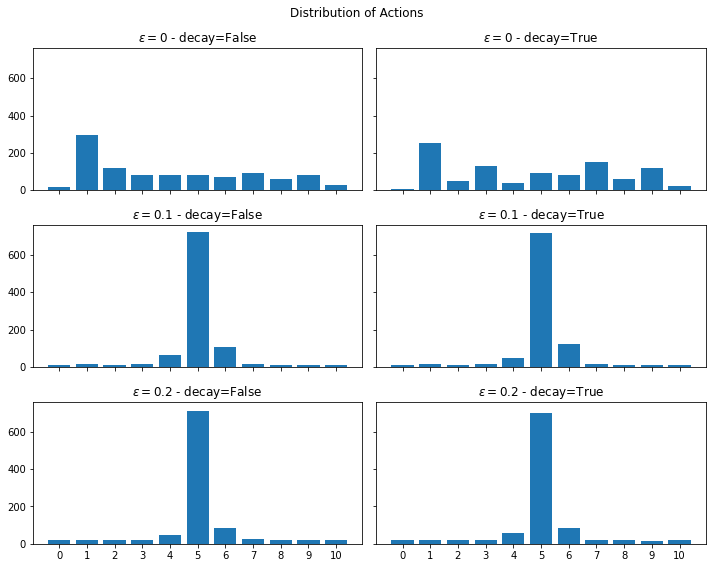

Percentage of actions selected:


,arm=0,arm=1,arm=2,arm=3,arm=4,arm=5,arm=6,arm=7,arm=8,arm=9,arm=10
$\epsilon=$0 - decay=False,1.510,29.476,12.000,8.000,8.000,8.000,7.000,9.000,6.000,8.000,3.014
$\epsilon=$0 - decay=True,0.430,25.551,5.000,13.000,4.000,9.000,8.000,15.000,6.000,12.000,2.019
$\epsilon=$0.1 - decay=False,1.199,1.562,1.057,1.734,6.384,72.446,10.872,1.644,1.131,1.078,0.893
$\epsilon=$0.1 - decay=True,1.252,1.771,1.280,1.424,5.062,71.930,12.386,1.772,1.263,1.040,0.820
$\epsilon=$0.2 - decay=False,2.042,2.143,1.900,1.978,4.543,71.231,8.239,2.313,1.949,1.858,1.804
$\epsilon=$0.2 - decay=True,1.975,2.292,1.854,2.066,5.697,70.190,8.285,2.091,2.010,1.734,1.806


In [12]:
bins = np.linspace(0, k-1, k)

fig, axs = plt.subplots(3,2, figsize=(10, 8), 
                        facecolor='w', edgecolor='k', 
                        sharex=True, sharey=True)
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

zipped = [(x,y) for x in epsilon_list for y in decay_list]

for i, (epsilon, decay) in enumerate(zipped):
    axs[i].bar(bins, eps_selection_list[i])
    axs[i].set_title("$\epsilon=$" + str(epsilon) + ' - decay=' + str(decay))
    axs[i].set_xticks(list(range(0,k)))

plt.suptitle('Distribution of Actions')
fig.tight_layout()
plt.show()

opt_per = np.array(eps_selection_list)/iters * 100
df = pd.DataFrame(opt_per, 
                  index=[("$\epsilon=$" + str(epsilon) + ' - decay=' + str(decay)) for (epsilon, decay) in zipped],
                  columns=["arm=" + str(x) for x in range(0, k)])
print("Percentage of actions selected:")
df

In [13]:
df_reward = pd.DataFrame(np.around(max_reward,3), 
                         index=[("$\epsilon=$" + str(epsilon) + ' - decay=' + str(decay)) for (epsilon, decay) in zipped],
                         columns=['Reward'])
df_reward

,Reward
$\epsilon=$0 - decay=False,5.863
$\epsilon=$0 - decay=True,6.192
$\epsilon=$0.1 - decay=False,9.388
$\epsilon=$0.1 - decay=True,9.363
$\epsilon=$0.2 - decay=False,9.062
$\epsilon=$0.2 - decay=True,9.054


# Conclusion
- Too much epilson affects the model as the agent may explore too much
- Too low of an epsilon makes the agent explore too little, and may not find the local maxima
- With decay, the overall results improved when the epilson is high, but worsen vice versa